In [2]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from datetime import datetime, timedelta, date
from ipywidgets import interact
import itertools
from tabulate import tabulate

import requests
from bs4 import BeautifulSoup
import geopandas as gpd
from prettytable import PrettyTable

In [19]:
url = 'https://www.worldometers.info/coronavirus/#countries'

# make a GET request to fetch the raw HTML content
web_content = requests.get(url).content

# parse the html content
soup = BeautifulSoup(web_content, "html.parser")

# remove any newlines and extra spaces from left and right
extract_contents = lambda row: [x.text.replace('\n', '') for x in row]

# find all table rows and data cells within
stats = [] 
all_rows = soup.find_all('tr')

for row in all_rows:
    stat = extract_contents(row.find_all('td'))   
# the data that we require is a list of length 12
    if len(stat) == 12:
        stats.append(stat)
        
#now convert the data into a pandas dataframe for further processing
new_cols = ["Country", "Total Cases", "New Cases", "Total deaths", "New Deaths", "Total Recovered", "Active Cases",
           "Serious/Critical", "Tot. Cases/1M pop", "Deaths/1M pop", "Total Tests", "Tests/1M pop"]
country_data = pd.DataFrame(data = stats, columns = new_cols)
#country_data['Date'] = date.today()
country_data

,Country,Total Cases,New Cases,Total deaths,New Deaths,Total Recovered,Active Cases,Serious/Critical,Tot. Cases/1M pop,Deaths/1M pop,Total Tests,Tests/1M pop


In [7]:
filename = "data_"+str(date.today())+".csv"
country_data.to_csv(os.path.join('data_world',filename))

In [6]:
csv_files = glob.glob(os.path.join('data_world','data_*.csv'))
#print csv_files which is a list of filenames
print(csv_files)
 
#intialize empty list that we will append dataframes to
list_data = []
 
 
#write a for loop that will go through each of the file name through globbing and the end result will be the list of dataframes
for filename in csv_files:
    data = pd.read_csv(filename)
    list_data.append(data)
 
#print list_data which is a list of dataframes
list_data
 
cdf = pd.concat(list_data,ignore_index=False, sort=True)
#cdf.head()
cdf.to_csv('combined_world.csv')

['data_world/data_2020-04-06.csv', 'data_world/data_2020-04-08.csv', 'data_world/data_2020-04-07.csv', 'data_world/data_2020-04-10.csv', 'data_world/data_2020-04-09.csv']


In [20]:
# Columns to use
colsList = ['Active Cases', 'Total deaths']

# Get dataframe for Countrys
def getCountryCovidFr(CountryName):
    CountryCovidFr = cdf[cdf['Country'] == CountryName]
    CountryCovidFr.sort_values(by=['Date'], inplace=True, ascending=True)
    return CountryCovidFr

def convertDateToReadableFormat(dateList):
    dtObjectList = []
    for dateInt in dateList:
        dateStr = str(dateInt)
        print(dateStr)
        x = datetime(int(dateStr[:4]), int(dateStr[5:7]), int(dateStr[8:]))
        dtObjectList.append(x)
    dateTimeList = [dtObject.strftime('%y-%m-%d') for dtObject in dtObjectList]
    return dateTimeList, dtObjectList

# Function for plotting  state data
def plotCountryData(CountryName, logScale=False, tablesToUse='all'):
    '''
    tablestoUse is either 'all' or a list of table names from colsList
    '''
    CountryCovidFr = getCountryCovidFr(CountryName)
    dateList = CountryCovidFr['Date'].tolist()
    readableDateList, _ = convertDateToReadableFormat(dateList)
    # Data is latest to oldest
    #readableDateList.reverse()
    
    CountryCovidDataDict = {}
    for col in colsList:
        dataList = CountryCovidFr[col].tolist()
        #dataList.reverse()
        CountryCovidDataDict[col] = dataList
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    if tablesToUse == 'all':
        for col in colsList:
            ax.plot(readableDateList, CountryCovidDataDict[col], marker='o', label=col);
    else:
        for tableToUse in tablesToUse:
            ax.plot(readableDateList, CountryCovidDataDict[tableToUse], marker='o', label=tableToUse);

    plt.xticks(rotation=45, ha="right");
    
    if logScale:
        plt.yscale('log')

    every_nth = 3
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)
    ax.legend(loc='upper left');
    plt.xlabel('Date', fontsize=18);
    plt.ylabel('Number of cases', fontsize=18);
    plt.grid(axis='y')

2020-04-06
2020-04-06
2020-04-07
2020-04-07
2020-04-08
2020-04-08
2020-04-09
2020-04-09


/home/soumik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Active Cases,Country,Date,Deaths/1M pop,New Cases,New Deaths,Serious/Critical,Tests/1M pop,Tot. Cases/1M pop,Total Cases,Total Recovered,Total Tests,Total deaths,Unnamed: 0,Unnamed: 0.1
26,"3,852",India,2020-04-06,0.09,+9,NaN,NaN,101,3,"4,298",328,"139,954",118,26,26.0
239,"3,843",India,2020-04-06,0.09,+701,+19,NaN,93,3,"4,289",328,"128,320",118,239,239.0
24,"4,267",India,2020-04-07,0.1,+489,+18,NaN,102,3,"4,778",375,"140,293",136,24,24.0
240,"3,843",India,2020-04-07,0.09,+701,+19,NaN,93,3,"4,289",328,"128,320",118,240,240.0
23,"4,848",India,2020-04-08,0.1,+129,+4,NaN,102,4,"5,480",468,"140,293",164,23,23.0
237,"4,723",India,2020-04-08,0.1,+573,+24,NaN,102,4,"5,351",468,"140,293",160,237,237.0
23,"5,232",India,2020-04-09,0.1,NaN,NaN,NaN,121,4,"5,916",506,"167,235",178,23,NaN
237,"5,232",India,2020-04-09,0.1,+565,+18,NaN,121,4,"5,916",506,"167,235",178,237,NaN


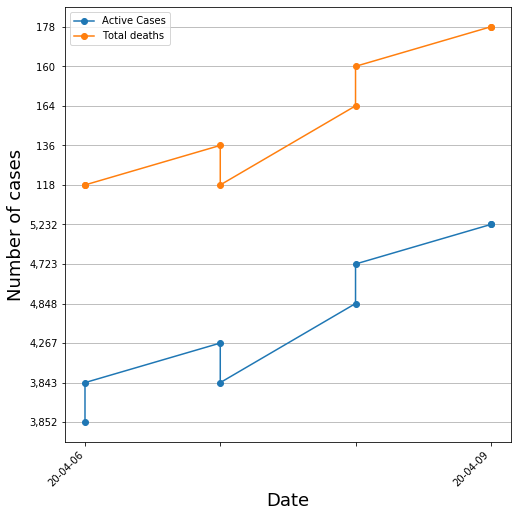

In [22]:
plotCountryData('India', tablesToUse=['Active Cases', 'Total deaths'])
getCountryCovidFr('India')

# comparing/training it with available data

# prediction

# Is the pandemic following same mathematical distribution globally ? If not, is it same in continents ?

# Is the pattern same for worst hit countries ?

# Inferences (as you are doing) from the above country specific curves with recommendations obtained from their analysis. 

# Can a weighing factor be assigned to each of  the three additional parameters (or overall five parameters) which you are considering. 

# Which factor is most essential to flatten the curve?

# For India, how is the outbreak pattern in different states. Is it inline with the entire country or zone-specific ?